# Reading and Writing Data in Text Format

pandas features a number of functions for reading tabular data as a DataFrame object

Table 6-1 summarizes some of them, though read_csv and read_table are likely the ones you’ll use the most

Table 6-1. Parsing functions in pandas
<p align='center'>
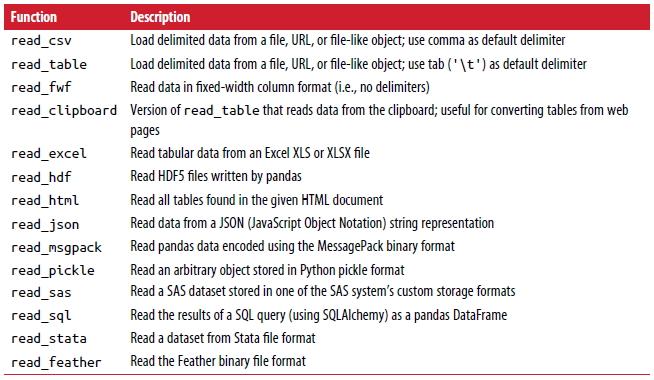
</p>

I’ll give an overview of the mechanics of these functions, which are meant to convert text data into a DataFrame

The optional arguments for these functions may fall into a few categories:

* Indexing

  * Can treat one or more columns as the returned DataFrame, and whether to get column names from the file, the user, or not at all

* Type inference and data conversion

  * This includes the user-defined value conversions and custom list of missing value markers

* Datetime parsing

  * Includes combining capability, including combining date and time information spread over multiple columns into a single column in the result

* Iterating

  * Support for iterating over chunks of very large files

* Unclean data issues

  *  Skipping rows or a footer, comments, or other minor things like numeric data with thousands separated by commas


In [55]:
!mkdir examples

mkdir: cannot create directory ‘examples’: File exists


In [56]:
import pandas as pd
df = pd.DataFrame([[1, 2, 3, 4, 'hello'], 
                   [5, 6, 7, 8, 'world'], 
                   [9, 10, 11, 12, 'foo']],
                   columns=['a', 'b', 'c', 'd', 'message'])
df.to_csv('examples/ex1.csv', index=False)

Handling dates and other custom types can require extra effort. Let’s start with a small comma-separated (CSV) text file:

In [57]:
!cat examples/ex1.csv

a,b,c,d,message
1,2,3,4,hello
5,6,7,8,world
9,10,11,12,foo


Since this is comma-delimited, we can use read_csv to read it into a DataFrame:

In [58]:
df = pd.read_csv('examples/ex1.csv')

In [59]:
df

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


We could also have used read_table and specified the delimiter:

In [60]:
pd.read_table('examples/ex1.csv', sep=',')

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


A file will not always have a header row. Consider this file:

In [61]:
df = pd.DataFrame([[1, 2, 3, 4, 'hello'],
                   [5, 6, 7, 8, 'world'],
                   [9, 10, 11, 12, 'foo']])
df.to_csv('examples/ex2.csv', index=False, header=False)

In [62]:
!cat examples/ex2.csv

1,2,3,4,hello
5,6,7,8,world
9,10,11,12,foo


To read this file, you have a couple of options. You can allow pandas to assign default column names, or you can specify names yourself:

In [63]:
pd.read_csv('examples/ex2.csv', header=None)

,0,1,2,3,4
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


In [64]:
pd.read_csv('examples/ex2.csv', names=['a', 'b', 'c', 'd', 'message'])

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


Suppose you wanted the message column to be the index of the returned DataFrame

You can either indicate you want the column at index 4 or named 'message' using the index_col argument:

In [65]:
names = ['a', 'b', 'c', 'd', 'message']

In [66]:
pd.read_csv('examples/ex2.csv', names=names, index_col='message')

,a,b,c,d
message,,,,
hello,1,2,3,4
world,5,6,7,8
foo,9,10,11,12


In the event that you want to **form a hierarchical index from multiple columns**, pass a list of column numbers or names:

In [67]:
import numpy as np
key1 = sum([['one' for i in range(4)], ['two' for i in range(4)]], [])
key2 = sum([list('abcd') for i in range (2)], [])
value1 = np.linspace(1, 15, 8).astype(np.int)
value2 = np.linspace(2, 16, 8).astype(np.int)
df = pd.DataFrame({'key1': [i for i in key1],
                   'key2': [i for i in key2],
                   'value1': [i for i in value1],
                   'value2': [i for i in value2]})
df.to_csv('examples/csv_mindex.csv', index=False)

In [68]:
!cat examples/csv_mindex.csv

key1,key2,value1,value2
one,a,1,2
one,b,3,4
one,c,5,6
one,d,7,8
two,a,9,10
two,b,11,12
two,c,13,14
two,d,15,16


In [69]:
parsed = pd.read_csv('examples/csv_mindex.csv',
                     index_col=['key1', 'key2'])

In [70]:
parsed

value1  value2
key1 key2                
one  a          1       2
     b          3       4
     c          5       6
     d          7       8
two  a          9      10
     b         11      12
     c         13      14
     d         15      16

In some cases, **a table might not have a fixed delimiter, using whitespace or some other pattern to separate fields **

Consider a text file that looks like this:

In [71]:
df = pd.DataFrame({'A': [-0.264438, 0.927272, -0.264273, -0.871858],
              'B': [-1.026059, 0.302904, -0.386314, -0.348382],
              'C': [-0.619500, -0.032399, -0.217601, 1.100491]},
             index=['aaa', 'bbb', 'ccc', 'ddd'])
df.to_csv('examples/ex3.txt', sep=' ')

In [72]:
list(open('examples/ex3.txt'))

[' A B C\n',
 'aaa -0.264438 -1.026059 -0.6195\n',
 'bbb 0.927272 0.302904 -0.032399\n',
 'ccc -0.264273 -0.386314 -0.217601\n',
 'ddd -0.871858 -0.348382 1.100491\n']

While you could do some munging by hand, the fields here are separated by a variable amount of whitespace

In these cases, you can pass a regular expression as a delimiter for read_table. This can be expressed by the regular expression \s+, so we have then:

In [73]:
result = pd.read_table('examples/ex3.txt', sep='\s+')

In [74]:
result

,A,B,C
aaa,-0.264438,-1.026059,-0.619500
bbb,0.927272,0.302904,-0.032399
ccc,-0.264273,-0.386314,-0.217601
ddd,-0.871858,-0.348382,1.100491


**Because there was one fewer column name than the number of data rows, read_table infers that the first column should be the DataFrame’s index in this special case**

The parser functions have many additional arguments to help you handle the wide variety of exception file formats that occur

For example, you can skip the first, third, and fourth rows of a file with skiprows:


In [75]:
content = ['# hey!\n',
           'a,b,c,d,message\n',
           '# just wanted to make things more difficult for you\n',
           '# who reads CSV files with computers, anyway?\n',
           '1,2,3,4,hello\n',
           '5,6,7,8,world\n',
           '9,10,11,12,foo\n']
           
with open('examples/ex4.csv', 'w+') as file:
  for i in content:
    file.write(i)

In [76]:
!cat examples/ex4.csv

# hey!
a,b,c,d,message
# just wanted to make things more difficult for you
# who reads CSV files with computers, anyway?
1,2,3,4,hello
5,6,7,8,world
9,10,11,12,foo


In [77]:
pd.read_csv('examples/ex4.csv', skiprows=[0, 2, 3])

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


Handling missing values is an important and frequently nuanced part of the file parsing process

**Missing data is usually either not present (empty string) or marked by some sentinel value**

By default, pandas uses a set of commonly occurring sentinels, such as NA and NULL:

In [78]:
df = pd.DataFrame({'something': ['one', 'two', 'three'],
                   'a': [1, 5, 9],
                   'b': [2, 6, 10],
                   'c': [3, '', 11],
                   'd': [4, 8, 12],
                   'message': ['NA', 'world', 'foo']})
df.to_csv('examples/ex5.csv', index=False)

In [79]:
!cat examples/ex5.csv

something,a,b,c,d,message
one,1,2,3,4,NA
two,5,6,,8,world
three,9,10,11,12,foo


In [80]:
result = pd.read_csv('examples/ex5.csv')

In [81]:
result

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


In [82]:
pd.isnull(result)

,something,a,b,c,d,message
0,False,False,False,False,False,True
1,False,False,False,True,False,False
2,False,False,False,False,False,False


The na_values option can take either a list or set of strings to consider missing values:

In [83]:
result = pd.read_csv('examples/ex5.csv', na_values=['NULL'])

In [84]:
result

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


Different NA sentinels can be specified for each column in a dict:

In [85]:
sentinels = {'message': ['foo', 'NA'], 'something': ['two']}

In [86]:
pd.read_csv('examples/ex5.csv', na_values=sentinels)

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,NaN,5,6,NaN,8,world
2,three,9,10,11.0,12,NaN


Table 6-2 lists some frequently used options in pandas.read_csv and pandas.read _table

Table 6-2. Some read_csv/read_table function arguments
<p align='center'>
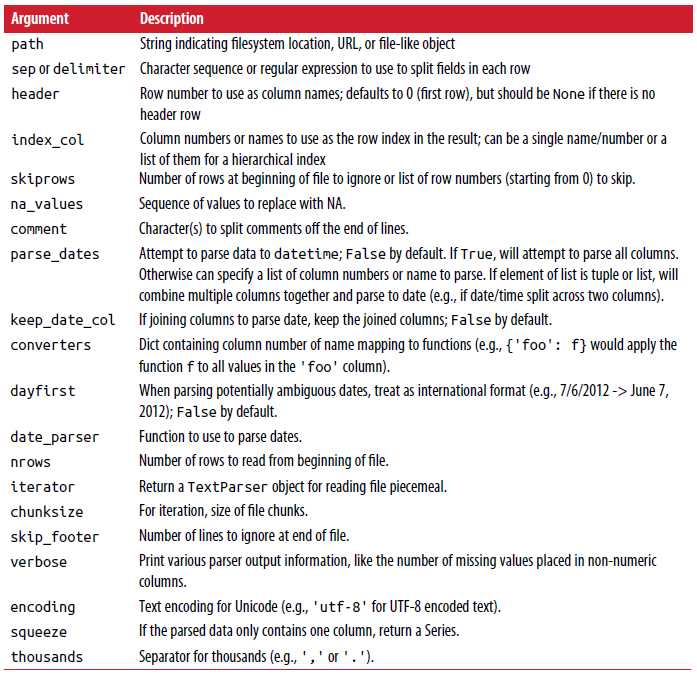
</p>

## Reading Text Files in Pieces

**When processing very large files** or figuring out the right set of arguments to correctly process a large file, **you may only want to read in a small piece of a file or iterate through smaller chunks of the file**

Before we look at a large file, we make the pandas display settings more compact:

In [87]:
pd.options.display.max_rows = 10

Now we have:

In [88]:
ex6 = 'https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition/examples/ex6.csv'
result = pd.read_csv(ex6)

In [89]:
result

,one,two,three,four,key
0,0.467976,-0.038649,-0.295344,-1.824726,L
1,-0.358893,1.404453,0.704965,-0.200638,B
2,-0.501840,0.659254,-0.421691,-0.057688,G
3,0.204886,1.074134,1.388361,-0.982404,R
4,0.354628,-0.133116,0.283763,-0.837063,Q
...,...,...,...,...,...
9995,2.311896,-0.417070,-1.409599,-0.515821,L
9996,-0.479893,-0.650419,0.745152,-0.646038,E
9997,0.523331,0.787112,0.486066,1.093156,K
9998,-0.362559,0.598894,-1.843201,0.887292,G


If you want to only **read a small number of rows** (avoiding reading the entire file), specify that with nrows:

In [90]:
pd.read_csv(ex6, nrows=5)

,one,two,three,four,key
0,0.467976,-0.038649,-0.295344,-1.824726,L
1,-0.358893,1.404453,0.704965,-0.200638,B
2,-0.501840,0.659254,-0.421691,-0.057688,G
3,0.204886,1.074134,1.388361,-0.982404,R
4,0.354628,-0.133116,0.283763,-0.837063,Q


To read a file in pieces, specify a **chunksize as a number of rows:**

In [91]:
chunker = pd.read_csv(ex6, chunksize=1000)

In [92]:
chunker

The TextParser object returned by read_csv **allows you to iterate over the parts of the file according to the chunksize**

For example, we can iterate over ex6.csv, aggregating the value counts in the 'key' column like so:

In [93]:
chunker = pd.read_csv(ex6, chunksize=1000)

tot = pd.Series([])
for piece in chunker:
  tot = tot.add(piece['key'].value_counts(), fill_value=0)

tot = tot.sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
tot[:10]

E    368.0
X    364.0
L    346.0
O    343.0
Q    340.0
M    338.0
J    337.0
F    335.0
K    334.0
H    330.0
dtype: float64

TextParser is also equipped with a get_chunk method that enables you to read pieces of an arbitrary size

## Writing Data to Text Format

Data can also be exported to a delimited format. Let’s consider one of the CSV files read before:

In [95]:
data = pd.read_csv('examples/ex5.csv')

In [96]:
data

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


Using DataFrame’s to_csv method, we can write the data out to a comma-separated file:

In [97]:
data.to_csv('examples/out.csv')

In [98]:
!cat examples/out.csv

,something,a,b,c,d,message
0,one,1,2,3.0,4,
1,two,5,6,,8,world
2,three,9,10,11.0,12,foo


Other delimiters can be used, of course (writing to sys.stdout so it prints the text result to the console):

In [99]:
import sys

In [100]:
data.to_csv(sys.stdout, sep='|')

|something|a|b|c|d|message
0|one|1|2|3.0|4|
1|two|5|6||8|world
2|three|9|10|11.0|12|foo


Missing values appear as empty strings in the output. You might want to denote them by some other sentinel value:

In [101]:
data.to_csv(sys.stdout, na_rep='NULL')

,something,a,b,c,d,message
0,one,1,2,3.0,4,NULL
1,two,5,6,NULL,8,world
2,three,9,10,11.0,12,foo


With no other options specified, both the row and column labels are written. Both of these can be disabled:

In [102]:
data.to_csv(sys.stdout, index=False, header=False)

one,1,2,3.0,4,
two,5,6,,8,world
three,9,10,11.0,12,foo


You can also write only a subset of the columns, and in an order of your choosing:

In [103]:
data.to_csv(sys.stdout, index=False, columns=['a', 'b', 'c'])

a,b,c
1,2,3.0
5,6,
9,10,11.0


Series also has a to_csv method:

In [104]:
dates = pd.date_range('1/1/2000', periods=7)

In [105]:
ts = pd.Series(np.arange(7), index=dates)

In [106]:
ts.to_csv('examples/tseries.csv')

In [107]:
!cat examples/tseries.csv

,0
2000-01-01,0
2000-01-02,1
2000-01-03,2
2000-01-04,3
2000-01-05,4
2000-01-06,5
2000-01-07,6


## Working with Delimited Formats

It’s possible to load most forms of tabular data from disk using functions like pandas.read_table. In some cases, however, some manual processing may be necessary

It’s not uncommon to receive a file with one or more malformed lines that trip up read_table

To illustrate the basic tools, consider a small CSV file:



In [108]:
import csv
df = pd.DataFrame([[1, 2, 3], [1, 2, 3]], columns=('a', 'b', 'c'))
df.to_csv('examples/ex7.csv', index=False, quoting=csv.QUOTE_ALL, escapechar="")

In [109]:
!cat examples/ex7.csv

"a","b","c"
"1","2","3"
"1","2","3"


For any file with a single-character delimiter, you can use Python’s built-in csv module

To use it, pass any open file or file-like object to csv.reader:

In [110]:
import csv
f = open('examples/ex7.csv')

reader = csv.reader(f)

Iterating through the reader like a file yields tuples of values with any quote characters removed:

In [111]:
for line in reader:
  print(line)

['a', 'b', 'c']
['1', '2', '3']
['1', '2', '3']


From there, it’s up to you to do the wrangling necessary to put the data in the form that you need it

Let’s take this step by step. First, we read the file into a list of lines:

In [112]:
with open('examples/ex7.csv') as f:
  lines = list(csv.reader(f))

Then, we split the lines into the header line and the data lines:

In [113]:
header, values = lines[0], lines[1:]

Then we can create a dictionary of data columns using a dictionary comprehension and the expression zip(*values), which transposes rows to columns:

In [114]:
data_dict = {h: v for h, v in zip(header, zip(*values))}

In [116]:
data_dict

{'a': ('1', '1'), 'b': ('2', '2'), 'c': ('3', '3')}

CSV files come in many different flavors. **To define a new format with a different delimiter, string quoting convention, or line terminator, we define a simple subclass of csv.Dialect:**

In [128]:
class my_dialect(csv.Dialect):
  lineterminator = '\n'
  delimiter = ';'
  quotechar = '"'
  quoting = csv.QUOTE_MINIMAL

#reader = csv.reader(f, dialect=my_dialect)

We can also give individual CSV dialect parameters as keywords to csv.reader without having to define a subclass:

In [130]:
#reader = csv.reader(f, delimiter='|')

The possible options (attributes of csv. Dialect) and what they do can be found in Table 6-3

Table 6-3. CSV dialect options
<p align='center'>
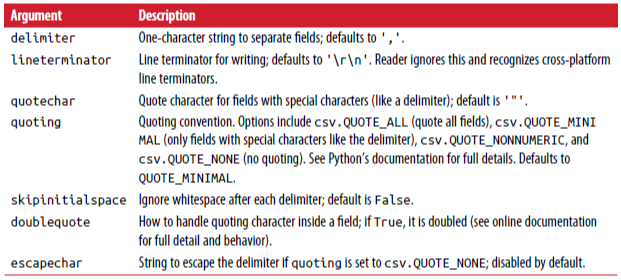
</p>

To write delimited files manually, you can use csv.writer

It accepts an open, writa blefile object and the same dialect and format options as csv.reader:

In [132]:
with open('mydata.csv', 'w') as f:
  writer = csv.writer(f, dialect=my_dialect)
  writer.writerow(('one', 'two', 'three'))
  writer.writerow(('1', '2', '3'))
  writer.writerow(('4', '5', '6'))
  writer.writerow(('7', '8', '9'))

## JSON Data

JSON (short for JavaScript Object Notation) has become one of the standard formats for sending data by HTTP request between web browsers and other applications

**It is a much more free-form data format than a tabular text** form like CSV. Here is an example:

In [133]:
obj = """
{"name": "Wes",
"places_lived": ["United States", "Spain", "Germany"],
"pet": null,
"siblings": [{"name": "Scott", "age": 30, "pets": ["Zeus", "Zuko"]},
{"name": "Katie", "age": 38,
"pets": ["Sixes", "Stache", "Cisco"]}]
}
"""